In [ ]:
import ee
import geemap

In [ ]:
from datetime import date, datetime
from dateutil.relativedelta import relativedelta
from skimage import io
import numpy as np
import ee
import geemap
import logging
import multiprocessing
import os
import requests
import shutil
# from retry import retry
from datetime import datetime
import matplotlib.pyplot as plt

from collections import namedtuple

In [ ]:
from utils.utils import *
from uiils.ee_utils import *

4/1AfgeXvvmWF-_z0qOvwsZK597gUnHMOdSTjpY6CStI-buWxqNvRlGoRU19og

In [ ]:
Map = geemap.Map()

In [ ]:
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com')

# A Function to retrive S1 and S2

has two inputs:
*   date
*   roi


Returns:
*   s1
*   s2 image




## Old functins for easy easy access `func__`
---

In [ ]:
from datetime import date, datetime
from dateutil.relativedelta import relativedelta

I lowered scale from 1000 to 100 becuase I know my images are not that big, in future make sure to raise it to 1000 if error happens.

In [ ]:
def mosaic_covers_roi(imgecollection, roi, ref_band_name = 'B2',acceptance_rate = 0.95,scale = 100 , optimum_pix_num = 10000):
  '''
  the input is an image collection that has beed filterd by date and boundry

  Returns
  ---
  *  `True`  if the ratio of image to whole area is bigger that acceptance rate
  *  `False` the collection is empy or the ratio of image to whole area is smaller that acceptance rate
  '''
  if is_col_empty(imgecollection): # first we check if collection is not empty
    print('Collection was empty!')
    return False


  img = imgecollection.mosaic().clip(roi).select(ref_band_name) # convertin image to mosaic and clip it by roi
  mask = img.mask().clip(roi) # create the mask and clip it by roi - clip is important beucase mask convers the whole globe

  img_pix_dict = img.reduceRegion(reducer=ee.Reducer.count(),geometry= roi,scale=scale).getInfo() # counting pixels
  msk_pix_dict = mask.reduceRegion(reducer=ee.Reducer.count(),geometry= roi,scale=scale).getInfo()

  img_pix_int = dict_to_int(img_pix_dict) # count() output is a dict , we need numbers 
  msk_pix_int = dict_to_int(msk_pix_dict)

 # if we chose the scale too high it the reuslat woudlnt be acurate, so we worte this functino as a 
 # recursive function, so it comes back and devides sacle by a factor of 10 and tries again
  if msk_pix_int <= optimum_pix_num:
    print('WARNING: low pixel nubmer - recurse activated - scale droped to ',round(scale/10))
    return mosaic_covers_roi(imgecollection, roi, ref_band_name, acceptance_rate,scale = round(scale/10))  # the return is crosial for a recursive func, i missed it the first time
  else:
    print(f'Mosiac Covers {(img_pix_int/msk_pix_int) * 100} percent of the roi',' - detail: ',f'Image Pixels = {img_pix_int} / All Pixels = {msk_pix_int}')
    #print(f'Image Pixels = {img_pix_int} / All Pixels = {msk_pix_int}')
    if img_pix_int >= acceptance_rate * msk_pix_int: 
      print('Mosaic Coverege Accepted')
      return True
    else:
      print('Mosaic Coverege Not Accepted')
      return False


---

## New Functions
---

### add to current time
used [this doc ](https://bobbyhadz.com/blog/python-add-months-to-date#:~:text=Use%20the%20relativedelta%20class%20from,with%20different%20numbers%20of%20days.)

we use this function to to expand the time span we are searching for `S2` images, if the S2 mosaic was not coplete in the month we want, it increases the span.

In [ ]:
date_time_obj = datetime.strptime('2020-01-02', '%Y-%m-%d')
new_date_time_obj= date_time_obj + relativedelta(months=+3)
print(new_date_time_obj)
print(new_date_time_obj.strftime('%Y-%m-%d'))
print(type(new_date_time_obj.strftime('%Y-%m-%d')))

2020-04-02 00:00:00
2020-04-02
<class 'str'>


In [ ]:
def month_add(date:str,months_to_add = 1) -> str:
  ''' date should be string in `'2020-02-01' format` '''
  date_time_obj = datetime.strptime(date, '%Y-%m-%d')
  new_date_time_obj= date_time_obj + relativedelta(months=+months_to_add)
  new_date_str = new_date_time_obj.strftime('%Y-%m-%d')
  return new_date_str

In [ ]:
month_add('2020-12-01',months_to_add = -1)

'2020-11-01'

In [ ]:
def day_add(date:str,days_to_add = 2) -> str:
  ''' date should be string in `'2020-02-01' format` '''
  date_time_obj = datetime.strptime(date, '%Y-%m-%d')
  new_date_time_obj= date_time_obj + relativedelta(days=+days_to_add)
  new_date_str = new_date_time_obj.strftime('%Y-%m-%d')
  return new_date_str

In [ ]:
day_add('2020-12-30',days_to_add = 2)

'2021-01-01'

### list comprehensions but return more than one elemnt
I found this cool and pythonic techniqe from [this post](https://stackoverflow.com/questions/20196159/how-to-append-multiple-values-to-a-list-in-python)

### the idea behind buffering
so s2 images an area evry five days, so the sampling rate is 5 days, so if we find an snowy s2 image we assume that the whole five days which is 2 days before and 2 days after, are snowy, we add all these days into a list, as snowy days to later check s1 images and remove those that have the same date as this list.

In [ ]:
def day_buffer(days_list: list,no_duplicate=True)->list:
  f0 = lambda x: day_add(x,days_to_add = 0)
  fp1 = lambda x: day_add(x,days_to_add = 1)
  fp2 = lambda x: day_add(x,days_to_add = 2)
  fm1 = lambda x: day_add(x,days_to_add = -1)
  fm2 = lambda x: day_add(x,days_to_add = -2)

  bufferd = [f(x) for x in days_list for f in (fm2,fm1,f0,fp1,fp2)]
  if no_duplicate:
    bufferd_no_duplicate = list(dict.fromkeys(bufferd))
    return bufferd_no_duplicate
  else:
    return bufferd

In [ ]:
dummy_dates = ['2020-06-06','2020-06-06','2020-06-02','2020-06-07','2020-06-12']
x =day_buffer(dummy_dates)
x.sort()
print(x)

['2020-05-31', '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05', '2020-06-06', '2020-06-07', '2020-06-08', '2020-06-09', '2020-06-10', '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14']


In [ ]:
list(enumerate(dummy_dates)) 

[(0, '2020-06-06'),
 (1, '2020-06-06'),
 (2, '2020-06-02'),
 (3, '2020-06-07'),
 (4, '2020-06-12')]

In [ ]:
def list_intersection(in_list,ref_list):
  '''checks if the Items in the `in_list` are  in `ref_list`
  
  Returns
  ---
  index of items 
  '''
  intersect_list = [i for i,x in enumerate(in_list) if x in ref_list] # https://stackoverflow.com/questions/5419204/index-of-duplicates-items-in-a-python-list
  return intersect_list

In [ ]:
list_1 = ['2020-06-02','2020-06-07','2020-06-06','2020-06-07','2020-06-12'] # for example this is sen1 images
list_2 = ['2020-06-07','2020-06-12'] # this could be snowy images
list_intersection(list_1,list_2)

[1, 3, 4]

In [ ]:
def gee_list_item_remover(img_collection,img_indcies_list:list):
  '''
  the inputs are an image collection, and a list of indices of items to be remove
  and the output is a the image collection whitouth those items
  '''

  print('collection size before removing snowy dates: ',img_collection.size().getInfo())

  img_col_list = img_collection.toList(img_collection.size()) # converting imgcollection to gee list
  img_indcies_list.sort(reverse=True) # we sort the list dscening, bevuse our only option is to remove them one by one 
  #and if we remove for example index 0, then idex 1 becomes 0 and index 2 becomes 1 and so on,
  #to prevent this from happening we start removing form the largest index.
  for indx in img_indcies_list:
    print('image with index:',indx,' removed')
    img_col_list =img_col_list.splice(indx,1) # https://developers.google.com/earth-engine/apidocs/ee-list-splice

  removed_col =ee.ImageCollection(img_col_list) # convert the gee list back to imgcollection
  print('collection size after removing snowy dates: ',removed_col.size().getInfo())
  return removed_col

### retirive `S2` collection

In [ ]:
if not []:
  print('true')

true


In [ ]:
def get_s2(date_range: tuple,roi,max_cloud = 10,max_snow = 5):
  ''' 
  Inputs
  ---
  the date range two string element tupplein gee format  like `('2020-02-01','2020-03-01')`

  Algorithm
  ---
  the function first tries to find an image or images where the S2 scene fully covers the 
  `roi`.
  if the first attemp was not sucsessful then it will look for all the secnes that has some 
  overlap with the `roi`, with the user specified criteria, then it checks that the new collection
  can cover the whole `roi`, if not, it will expand the `date_range` defined by user by one motth 
  and start rcursing untill the valid result 

  Return
  ---
  the function reutrns an GEE `image collection`
  
  '''
  print('◍◍Finding S2')
  #first atempt
  s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
                    .filterDate(date_range[0], date_range[1]) \
                    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',max_cloud)) \
                    .filter(ee.Filter.lt('SNOW_ICE_PERCENTAGE',max_snow)) \
                    .filterBounds(roi) \
                    .filter(ee.Filter.contains('.geo', roi)) #this line checks if the scene completly covers the roi, which mean roi is in the scene


  #first attempt not secsessful:
  if  is_col_empty(s2): # if the collection is empty we go and check if therse a mosaic that covers the whole area
    print('◍No single scene coverge was found!')

    s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
                      .filterDate(date_range[0], date_range[1]) \
                      .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',max_cloud)) \
                      .filter(ee.Filter.lt('SNOW_ICE_PERCENTAGE',max_snow)) \
                      .filterBounds(roi)

    if mosaic_covers_roi(s2,roi,ref_band_name = 'B2'):
      print(f'◍Image Mosaic found in date range of {date_range[0]} to {date_range[1]}')
      return s2
    else:
      new_date = month_add(date_range[1])
      print(' - Month Range Expaned ', f'new range: {date_range[0]} -to- {new_date}')
      return get_s2((date_range[0],new_date),roi,max_cloud)

  #first attempt was secsessful:
  else:
    print('◍Single scene coverege was fount!')
    return s2

In [ ]:
def s1_col_func(start_date,end_date,roi,path,single_scene=False):
  if single_scene:
    s1_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterDate(start_date, end_date) \
        .filterBounds(roi) \
        .filter(ee.Filter.eq('resolution','H')) \
        .filter(ee.Filter.eq('instrumentMode','IW'))\
        .filter(ee.Filter.contains('.geo', roi)) \
        .filterMetadata('orbitProperties_pass', 'equals', path) 
  else:
    s1_collection = ee.ImageCollection('COPERNICUS/S1_GRD') \
        .filterDate(start_date, end_date) \
        .filterBounds(roi) \
        .filter(ee.Filter.eq('resolution','H')) \
        .filter(ee.Filter.eq('instrumentMode','IW'))\
        .filterMetadata('orbitProperties_pass', 'equals', path) 

  return s1_collection


In [ ]:
def get_s1(s2_collection,roi,max_snow = 10,priority_path = 'ASCENDING',check_second_priority_path = True,month_span = 1,retry_days = 0):
  '''
  Inputs
  ---
  * s2_collection
  * roi
  * max_snow: images with more snow thatn `max_snow` are considered as snowy 
  * priority_path: whether to first check for Ascending or Dscending Data
  * check_second_priority_path: whether to check the other path as well
  * retry_days: Increasing the date span by how many days in case of empty collection
  
  '''
  print('◍◍Finding S1')
  # if ASC is prioriy then DESC is the second prioriy and vice versa
  if priority_path == 'ASCENDING':
    second_priority = 'DESCENDING'
  else:
    second_priority = 'ASCENDING'


  mean_s2_date = mean_date(s2_collection.aggregate_array('system:time_start').getInfo()) #find the average date of S2 collection which will be the center of our S1 collection
  print('mean date: ', mean_s2_date)

  start_date = month_add(mean_s2_date,months_to_add =-1 * month_span) # 1 month before center date
  end_date   = month_add(mean_s2_date,months_to_add = month_span) # 1 month after  center date
  
  # in case of failure in the first atemmpet the reucrse will activate and increase the date span
  if retry_days !=0:
    start_date = day_add(start_date,days_to_add = -retry_days)
    end_date   = day_add(end_date,days_to_add =  retry_days)
  print('final date range: ',start_date,end_date)

  # S2 collection in the S1 Collection range to find the snowy days
  s2 = ee.ImageCollection('COPERNICUS/S2_SR') \
                  .filterDate(start_date, end_date) \
                  .filter(ee.Filter.greaterThan('SNOW_ICE_PERCENTAGE',max_snow)) \
                  .filterBounds(roi) #finding all the images in the two month range that are snowy

  # if an image is snowy we consider 2 days before and after it as snowy becuase S2 temporal resouliton is 5 days
  # the collection should be s2 and not the s2_collection, in the last version I made this mistake which resualted in wrong snowy dates.
  snowy_days = milsec2date(s2.aggregate_array('system:time_start').getInfo(),no_duplicate=True)
  print('Snowy days       : ',snowy_days)
  snowy_days_buffered = day_buffer(snowy_days)
  print('Snowy days Buffed: ',snowy_days_buffered)
  #====================================================================================================

  ## First we check if theres and Priority_path data that covers the whole area with a singe scene
  print(f'◍checking for {priority_path} single scene')
  s1_collection = s1_col_func(start_date,end_date,roi,path = priority_path,single_scene=True)


  ## if not,  we check if theres and Descending data that covers the whole area
  if is_col_empty(s1_collection) and check_second_priority_path:
    print(f'◍{priority_path} singe scene was not fount, checking {second_priority} single scene ...')
    s1_collection = s1_col_func(start_date,end_date,roi,path = second_priority,single_scene=True)

  if is_col_empty(s1_collection):
    print(f'◍No single scene was fount, checking {priority_path} mosaic ...')
    s1_collection = s1_col_func(start_date,end_date,roi,path = priority_path,single_scene=False)


  if (is_col_empty(s1_collection) or not mosaic_covers_roi(s1_collection,roi,ref_band_name = 'VV')) and check_second_priority_path:
    print(f'◍{priority_path} and {second_priority} singe scene was not fount, {priority_path} mosaic was not found,  checking {second_priority}  mosaic ...')
    s1_collection = s1_collection = s1_col_func(start_date,end_date,roi,path = second_priority,single_scene=False)
      
  if is_col_empty(s1_collection) or not mosaic_covers_roi(s1_collection,roi,ref_band_name = 'VV'):
    print('◍No S1 dataset was found!')
    if not check_second_priority_path: print('◍check_second_priority_path was set to True and check range was buffed by 5 days')

    return get_s1(s2_collection,roi,max_snow = max_snow+2,priority_path=priority_path,check_second_priority_path=True,retry_days = retry_days+5 ,month_span = month_span) # if the check only primiray didn't work for the first time,
    #probabily won't work, so we set check_second_priority_path to True
  else:

    s1_date_list = milsec2date(s1_collection.aggregate_array('system:time_start').getInfo(),no_duplicate=False)
    s1_snowy_dates = list_intersection(s1_date_list,snowy_days_buffered)

    s1_snow_removed_col = gee_list_item_remover(s1_collection,s1_snowy_dates)
    print('◍Collection Found!')
    return s1_snow_removed_col

# OSCD Dataset ROIs

## aguasclaras

In [ ]:
# b = 0.2
# x1 = -48.0
# x2 = x1 + b 
# y1 = -15.8
# y2 = y1 + b

# arb_roi = ee.Geometry.Polygon(
#     [[[x1, y1], [x1, y2], [x2, y2],[x2, y1]]], None, False
# )

In [ ]:
abudhabi = ee.Geometry.Polygon(
    [[[54.540252685546875,24.291407914292037],[54.61406707763672,24.291407914292037],[54.61406707763672,24.366488081551143],[54.540252685546875,24.366488081551143],[54.540252685546875,24.291407914292037]]], None, False
)
abudhabi_buffed = ee.Geometry.Polygon(
    [[[54.453049, 24.297666], [54.453049, 24.444649], [54.700241, 24.444649], [54.700241, 24.297666], [54.453049, 24.297666]]], None, False
)


aguasclaras = ee.Geometry.Polygon(
    [[[-48.049821853637695,-15.859636595173626],[-48.00158500671387,-15.859636595173626],[-48.00158500671387,-15.816368703814689],[-48.049821853637695,-15.816368703814689],[-48.049821853637695,-15.859636595173626]]], None, False
)
aguasclaras_buffed = ee.Geometry.Polygon(
    [[[-48.170776, -15.884206], [-48.170776, -15.765294], [-47.870397, -15.765294], [-47.870397, -15.884206], [-48.170776, -15.884206]]], None, False
)

aguasclaras_adj_goiania = ee.Geometry.Polygon(
   [[[-49.359512, -16.762817], [-49.359512, -16.627659], [-49.198151, -16.627659], [-49.198151, -16.762817], [-49.359512, -16.762817]]], None, False
)

#=================================================================================

beihai = ee.Geometry.Polygon(
    [[[109.4839096069336,21.531653397583106],[109.5560073852539,21.531653397583106],[109.5560073852539,21.615940981653758],[109.4839096069336,21.615940981653758],[109.4839096069336,21.531653397583106]]], None, False
)

beihai_buffed = ee.Geometry.Polygon(
    [[[109.386406, 21.472559], [109.386406, 21.616579], [109.556351, 21.616579], [109.556351, 21.472559], [109.386406, 21.472559]]], None, False
)
beihai_adj_gaoqiazhen = ee.Geometry.Polygon(
    [[[109.632225, 21.592639], [109.632225, 21.756311], [109.816246, 21.756311], [109.816246, 21.592639], [109.632225, 21.592639]]], None, False
)

#=================================================================================

beirut = ee.Geometry.Polygon(
    [[[35.46180725097656,33.80140293756829],[35.56772232055664,33.80140293756829],[35.56772232055664,33.918149900925556],[35.46180725097656,33.918149900925556],[35.46180725097656,33.80140293756829]]], None, False
)

beirut_adj_tripoli = ee.Geometry.Polygon(
    [[[35.801353, 34.397278], [35.801353, 34.468354], [35.897141, 34.468354], [35.897141, 34.397278], [35.801353, 34.397278]]], None, False
)


#=================================================================================

bercy = ee.Geometry.Polygon(
    [[[2.35931396484375,48.82065440440466],[2.4011993408203125,48.82065440440466],[2.4011993408203125,48.86663445988588],[2.35931396484375,48.86663445988588],[2.35931396484375,48.82065440440466]]], None, False
)

bercy_buffed_paris = ee.Geometry.Polygon(
    [[[2.241554, 48.805281], [2.241554, 48.908285], [2.419052, 48.908285], [2.419052, 48.805281], [2.241554, 48.805281]]], None, False
)


#=================================================================================

bordeaux = ee.Geometry.Polygon(
    [[[-0.6009864807128906,44.810583121135906],[-0.5508613586425781,44.810583121135906],[-0.5508613586425781,44.86681967562225],[-0.6009864807128906,44.86681967562225],[-0.6009864807128906,44.810583121135906]]], None, False
)

bordeaux_buffed = ee.Geometry.Polygon(
    [[[-0.716858, 44.787165], [-0.716858, 44.906438], [-0.508804, 44.906438], [-0.508804, 44.787165], [-0.716858, 44.787165]]], None, False
)

#=================================================================================

brasilia = ee.Geometry.Polygon(
    [[[-47.90768623352051,-15.766483542885926],[-47.86459922790527,-15.766483542885926],[-47.86459922790527,-15.726748339930374],[-47.90768623352051,-15.726748339930374],[-47.90768623352051,-15.766483542885926]]], None, False
)
brasilia_buffed = ee.Geometry.Polygon(
    [[[-47.91275, -15.860627], [-47.91275, -15.721874], [-47.792244, -15.721874], [-47.792244, -15.860627], [-47.91275, -15.860627]]], None, False
)

#=================================================================================

chongqing = ee.Geometry.Polygon(
    [[[106.26972198486328,29.379183431737633],[106.32225036621092,29.379183431737633],[106.32225036621092,29.449762750751052],[106.26972198486328,29.449762750751052],[106.26972198486328,29.379183431737633]]], None, False
)
chongqing_adj= ee.Geometry.Polygon(
    [[[106.438293, 29.507633], [106.438293, 29.711202], [106.577682, 29.711202], [106.577682, 29.507633], [106.438293, 29.507633]]], None, False
)



#=================================================================================

cupertino = ee.Geometry.Polygon(
    [[[-122.05372810363768,37.29761247853017],[-121.97330474853516,37.29761247853017],[-121.97330474853516,37.40125554281722],[-122.05372810363768,37.40125554281722],[-122.05372810363768,37.29761247853017]]], None, False
)
cupertino_buffed = ee.Geometry.Polygon(
    [[[-122.059479, 37.268042], [-122.059479, 37.433977], [-121.841812, 37.433977], [-121.841812, 37.268042], [-122.059479, 37.268042]]], None, False
)
cupertino_adj_losangles = ee.Geometry.Polygon(
    [[[-118.280182, 33.720913], [-118.280182, 33.883527], [-117.984238, 33.883527], [-117.984238, 33.720913], [-118.280182, 33.720913]]], None, False
)


#=================================================================================

dubai = ee.Geometry.Polygon(
    [[[55.19376754760742,25.0003719913183],[55.253849029541016,25.0003719913183],[55.253849029541016,25.073782645952882],[55.19376754760742,25.073782645952882],[55.19376754760742,25.0003719913183]]], None, False
)
dubai_buffed = ee.Geometry.Polygon(
    [[[55.031891, 24.960499], [55.031891, 25.147732], [55.264664, 25.147732], [55.264664, 24.960499], [55.031891, 24.960499]]], None, False
)
dubai_adj_sharje = ee.Geometry.Polygon(
    [[[55.201492, 25.149014], [55.201492, 25.287542], [55.440445, 25.287542], [55.440445, 25.149014], [55.201492, 25.149014]]], None, False
)

#=================================================================================

hongkong = ee.Geometry.Polygon(
    [[[114.22811508178711,22.276389027850755],[114.27858352661131,22.276389027850755],[114.27858352661131,22.34134341446177],[114.22811508178711,22.34134341446177],[114.22811508178711,22.276389027850755]]], None, False
)
hongkong_adj = ee.Geometry.Polygon(
    [[[114.102974, 22.273371], [114.102974, 22.3496], [114.227257, 22.3496], [114.227257, 22.273371], [114.102974, 22.273371]]], None, False
)

#=================================================================================

lasvegas = ee.Geometry.Polygon(
    [[[-115.27233123779295,35.98272917308846],[-115.20040512084961,35.98272917308846],[-115.20040512084961,36.06547452904167],[-115.27233123779295,36.06547452904167],[-115.27233123779295,35.98272917308846]]], None, False
)
lasvegas_buffed = ee.Geometry.Polygon(
    [[[-115.274734, 35.982382], [-115.274734, 36.212632], [-115.033722, 36.212632], [-115.033722, 35.982382], [-115.274734, 35.982382]]], None, False
)

#=================================================================================

milano = ee.Geometry.Polygon(
    [[[9.144916534423828,45.47289204060055],[9.20654296875,45.47289204060055],[9.20654296875,45.53304838316756],[9.144916534423828,45.53304838316756],[9.144916534423828,45.47289204060055]]], None, False
)
milano_buffed = ee.Geometry.Polygon(
    [[[9.033508, 45.427823], [9.033508, 45.557303], [9.302673, 45.557303], [9.302673, 45.427823], [9.033508, 45.427823]]], None, False
)

#=================================================================================

montpellier = ee.Geometry.Polygon(
    [[[3.8790321350097656,43.57777938919194],[3.927783966064453,43.57777938919194],[3.927783966064453,43.623898620281366],[3.8790321350097656,43.623898620281366],[3.8790321350097656,43.57777938919194]]], None, False
)
montpellier_buffed = ee.Geometry.Polygon(
    [[[3.805046, 43.518929], [3.805046, 43.644026], [3.985977, 43.644026], [3.985977, 43.518929], [3.805046, 43.518929]]], None, False
)

#=================================================================================

mumbai = ee.Geometry.Polygon(
    [[[72.90166854858398,19.02560799192205],[72.95333862304688,19.02560799192205],[72.95333862304688,19.105270320255578],[72.90166854858398,19.105270320255578],[72.90166854858398,19.02560799192205]]], None, False
)
mumbai_buffed = ee.Geometry.Polygon(
    [[[72.812576, 18.999458], [72.812576, 19.138985], [73.037109, 19.138985], [73.037109, 18.999458], [72.812576, 18.999458]]], None, False
)


#=================================================================================

nantes = ee.Geometry.Polygon(
    [[[-1.5773963928222656,47.175595157859455],[-1.5121650695800781,47.175595157859455],[-1.5121650695800781,47.234139960174616],[-1.5773963928222656,47.234139960174616],[-1.5773963928222656,47.175595157859455]]], None, False
)
nantes_buffed = ee.Geometry.Polygon(
    [[[-1.738586, 47.148823], [-1.738586, 47.312482], [-1.460495, 47.312482], [-1.460495, 47.148823], [-1.738586, 47.148823]]], None, False
)

#=================================================================================

norcia = ee.Geometry.Polygon(
    [[[13.072099685668945,42.78078728488571],[13.113727569580078,42.78078728488571],[13.113727569580078,42.80686217357154],[13.072099685668945,42.80686217357154],[13.072099685668945,42.78078728488571]]], None, False
)

#=================================================================================

paris = ee.Geometry.Polygon(
    [[[2.3101329803466797,48.79759200667088],[2.3555374145507812,48.79759200667088],[2.3555374145507812,48.845061852890524],[2.3101329803466797,48.845061852890524],[2.3101329803466797,48.79759200667088]]], None, False
)
paris_buffed = ee.Geometry.Polygon(
    [[[2.265244, 48.686428], [2.265244, 48.806863], [2.510376, 48.806863], [2.510376, 48.686428], [2.265244, 48.686428]]], None, False
)



#=================================================================================

pisa = ee.Geometry.Polygon(
    [[[10.363025665283203,43.674824840428265],[10.44027328491211,43.674824840428265],[10.44027328491211,43.75832475194815],[10.363025665283203,43.75832475194815],[10.363025665283203,43.674824840428265]]], None, False
)
pisa_adj = ee.Geometry.Polygon(
    [[[10.455551, 43.60897], [10.455551, 43.684493], [10.650558, 43.684493], [10.650558, 43.60897], [10.455551, 43.60897]]], None, False
)

#=================================================================================

rennes = ee.Geometry.Polygon(
    [[[-1.6851997375488281,48.093789064833196],[-1.6209983825683594,48.093789064833196],[-1.6209983825683594,48.13252782014134],[-1.6851997375488281,48.13252782014134],[-1.6851997375488281,48.093789064833196]]], None, False
)

#=================================================================================

rio = ee.Geometry.Polygon(
    [[[-43.403377532958984,-22.98462936237051],[-43.36329460144042,-22.98462936237051],[-43.36329460144042,-22.951438332269273],[-43.403377532958984,-22.951438332269273],[-43.403377532958984,-22.98462936237051]]], None, False
)


#=================================================================================

saclay_e = ee.Geometry.Polygon(
    [[[2.21743583679,48.66681805477507],[2.2964859008789062,48.66681805477507],[2.2964859008789062,48.74026689109608],[2.21743583679,48.74026689109608],[2.21743583679,48.66681805477507]]], None, False
)


#=================================================================================

saclay_w = ee.Geometry.Polygon(
    [[[2.138385772705078,48.66681805477507],[2.21743583679,48.66681805477507],[2.21743583679,48.74026689109608],[2.138385772705078,48.74026689109608],[2.138385772705078,48.66681805477507]]], None, False
)


#=================================================================================

valencia = ee.Geometry.Polygon(
    [[[-0.4460620880126953,39.48165297689071],[-0.39713859558105463,39.48165297689071],[-0.39713859558105463,39.528738321820946],[-0.4460620880126953,39.528738321820946],[-0.4460620880126953,39.48165297689071]]], None, False
)
valencia_buffed = ee.Geometry.Polygon(
    [[[-0.486832, 39.351813], [-0.486832, 39.553816], [-0.300751, 39.553816], [-0.300751, 39.351813], [-0.486832, 39.351813]]], None, False
)






In [ ]:
roi = abudhabi

In [ ]:
features = geemap.fishnet(roi, rows=2, cols=2, delta=0.1)
#features = geemap.fishnet(roi, h_interval=0.05, v_interval=0.05)

In [ ]:
Map = geemap.Map(zoom=12)
Map.add_basemap('SATELLITE')
Map.addLayer(roi)

# Map.addLayer(abudhabi,{'color': 'fc0303'})
# Map.addLayer(aguasclaras,{'color': 'fc5e03'})
# Map.addLayer(beihai,{'color': 'fcad03'})
# Map.addLayer(beirut,{'color': 'fce303'})
# Map.addLayer(bercy,{'color': 'c6fc03'})
# Map.addLayer(bordeaux,{'color': '7bfc03'})
# Map.addLayer(brasilia,{'color': '35fc03'})
# Map.addLayer(chongqing,{'color': '03fc80'})
# Map.addLayer(cupertino,{'color': '03fcc6'})
# Map.addLayer(dubai,{'color': '03fce3'})
# Map.addLayer(hongkong,{'color': '03dffc'})
# Map.addLayer(lasvegas,{'color': '0394fc'})
# Map.addLayer(milano,{'color': '0362fc'})
# Map.addLayer(montpellier,{'color': '0318fc'})
# Map.addLayer(mumbai,{'color': '5a03fc'})
# Map.addLayer(nantes,{'color': '9803fc'})
# Map.addLayer(norcia,{'color': 'c203fc'})
# Map.addLayer(paris,{'color': 'fc03f4'})
# Map.addLayer(pisa,{'color': 'fc03ce'})
# Map.addLayer(rennes,{'color': 'fc03a5'})
# Map.addLayer(rio,{'color': 'fc036f'})
# Map.addLayer(saclay_e,{'color': 'fc0345'})
# Map.addLayer(saclay_w,{'color': 'fc032d'})
# Map.addLayer(valencia,{'color': 'fc0303'})

# Map.addLayer(features, {}, 'Grids')
Map.centerObject(roi)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [ ]:
# geometry = Map.user_roi.getInfo()
# print(geometry)

In [ ]:
# import pandas as pandas
# pandas.read_excel('/content/drive/MyDrive/Colab Notebooks/rgb2sar/ROIs.xlsx')

In [ ]:
def s1s2(roi, date = ('yyyy-mm-dd', 'yyyy-mm-dd'),priority_path = 'ASCENDING',check_second_priority_path = True,month_span = 1,max_cloud = 5,max_snow = 5,retry_days = 0 ):
  s2_col = get_s2(date,roi,max_cloud,max_snow)
  s1_col = get_s1(s2_col,roi,max_snow,priority_path,check_second_priority_path,month_span=month_span,retry_days=retry_days)
  return s2_col,s1_col

In [ ]:
# 'ASCENDING'
# 'DESCENDING'
s2_col,s1_col = s1s2(roi,date = ('2021-07-15', '2021-08-15'),priority_path = 'DESCENDING',max_cloud = 100,max_snow = 100,month_span = 1,retry_days=0)
# s2_col,s1_col_desc = s1s2(roi,date = ('2020-08-10', '2020-09-20'),priority_path = 'DESCENDING',max_cloud = 5)

◍◍Finding S2
◍Single scene coverege was fount!
◍◍Finding S1
mean date:  2021-07-30
final date range:  2021-06-30 2021-08-30
Snowy days       :  []
Snowy days Buffed:  []
◍checking for DESCENDING single scene
◍DESCENDING singe scene was not fount, checking ASCENDING single scene ...
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 687192 / All Pixels = 687192
Mosaic Coverege Accepted
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 687192 / All Pixels = 687192
Mosaic Coverege Accepted
collection size before removing snowy dates:  5
collection size after removing snowy dates:  5
◍Collection Found!


In [ ]:
sen2_print(s2_col)

CLOUDY_PIXEL_PERCENTAGE  : [52.209462, 79.669271, 57.767642, 32.901888, 88.999599, 34.115186, 14.378092, 50.236522, 16.080846, 6.71169, 16.190239, 5.87345, 20.647797, 50.794076, 23.319597, 4.9591, 13.761834, 3.98477, 71.033328, 53.982661, 73.58411, 2.642486, 10.242366, 2.602103, 7.819625, 24.19248, 8.130316, 0.402767, 5.701356, 0.385619, 6.803172, 21.699237, 7.382953, 1.211013, 10.401292, 1.217404, 9.459404, 21.985555, 10.140756]
CLOUD_SHADOW_PERCENTAGE  : [0, 0, 0, 0.008131, 0.001764, 0.007411, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.017159, 0.003007, 0.01537, 0, 0, 0, 0.000654, 0.008461, 0.000629, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.001393, 5e-06, 0.001299, 0.005716, 0.000111, 0.006989]
VEGETATION_PERCENTAGE    : [0, 9e-06, 0, 0.000528, 0.019239, 0.00059, 0.001679, 0.055609, 0.001594, 0, 0.020207, 0, 2.4e-05, 0.000109, 2.1e-05, 0.000332, 0.130545, 0.000283, 1.8e-05, 0.001762, 2.9e-05, 0.000197, 0.170985, 0.000203, 0.000123, 0.025778, 7.1e-05, 0, 0.064229, 0, 0.001562, 0.025961, 0.001411, 0, 0.035844, 

In [ ]:
sen1_print(s1_col) #.filter(ee.Filter.eq('relativeOrbitNumber_start', 30))

orbitProperties_pass : ['ASCENDING', 'ASCENDING', 'ASCENDING', 'ASCENDING', 'ASCENDING']
resolution           : ['H', 'H', 'H', 'H', 'H']
resolution_meters    : [10, 10, 10, 10, 10]
platform_number      : ['A', 'A', 'A', 'A', 'A']
productType          : ['GRD', 'GRD', 'GRD', 'GRD', 'GRD']
orbitNumber_start    : [38702, 38877, 39052, 39227, 39402]
orbitNumber_stop     : [38702, 38877, 39052, 39227, 39402]
Polarisation         : [['VV', 'VH'], ['VV', 'VH'], ['VV', 'VH'], ['VV', 'VH'], ['VV', 'VH']]
system:band_names    : [['VV', 'VH', 'angle'], ['VV', 'VH', 'angle'], ['VV', 'VH', 'angle'], ['VV', 'VH', 'angle'], ['VV', 'VH', 'angle']]
instrumentMode       : ['IW', 'IW', 'IW', 'IW', 'IW']
Date                 : ['2021-07-09', '2021-07-21', '2021-08-02', '2021-08-14', '2021-08-26']
relativeOrbitN_stop  : [130, 130, 130, 130, 130]
relativeOrbitN_start : [130, 130, 130, 130, 130]
cycleNumber          : [235, 236, 237, 238, 239]


In [ ]:
vis_params_s2 = {
  'min': 0.04,
  'max': 0.4,
  'bands': ['B4', 'B3', 'B2'],
}

# un comment this for Band 8 to be added to the map so you can check the correlation between NIR and radar backscatter

# vis_params_s2 = {
#   'min': 0.04,
#   'max': 0.4,
#   'bands': ['B8'],
# }

vis_params_s1 = {
    'min': -18,
    'max': -2,
    'bands': ['VV_db']
}

# vis params for dense urban structure, comment if images is too dark. (so the above one gets applied)

# vis_params_s1 = {
#     'min': -10,
#     'max': 10,
#     'bands': ['VV_db']
# }

## To Linear and back again!
as was said in the `Woodhouse pg. 324` we cannot averasge over `db` values.
so we convert the data into `linear` scale, then we use `.mean()` method

In [ ]:
#1 #https://gis.stackexchange.com/questions/424225/convert-sentinel-1-images-data-from-db-to-linear   #some how functions don't work but gives a good idea #used code in 'data_extractro_foliom' to translate to py
#2 #https://gis.stackexchange.com/questions/419849/google-earth-engine-python-expression-syntax       #correct way of writing the functions in python
#3 #https://developers.google.com/earth-engine/apidocs/ee-image-addbands
#4 #https://developers.google.com/earth-engine/apidocs/ee-image-expression


# adds band `VV_lin` to the images, code in link #1 doesn't work beucase it uses name `VV` and sets the replace in #3 to True which then overwrites the band we created with original `VV` !
def toLinear(db):
    lin = db.expression('pow(10, db / 10)', {'db': db.select('VV')}).rename('VV_lin')
    return db.addBands(lin)

# reads the added band `VV_linear` and converts it to db scale, we use this after we averaged over linear values.
def toDb(linear):
    lin = linear.expression('10 * log10(linear)', {'linear': linear.select('VV_lin')}).rename('VV_db')
    return linear.addBands(lin)

In [ ]:
s1_col = s1_col.map(toLinear)

In [ ]:
sen1_print(s1_col)

orbitProperties_pass : ['DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING', 'DESCENDING']
resolution           : ['H', 'H', 'H', 'H', 'H']
resolution_meters    : [10, 10, 10, 10, 10]
platform_number      : ['A', 'A', 'A', 'A', 'A']
productType          : ['GRD', 'GRD', 'GRD', 'GRD', 'GRD']
orbitNumber_start    : [24771, 24946, 25121, 25296, 25471]
orbitNumber_stop     : [24771, 24946, 25121, 25296, 25471]
Polarisation         : [['VV', 'VH'], ['VV', 'VH'], ['VV', 'VH'], ['VV', 'VH'], ['VV', 'VH']]
system:band_names    : [['VV', 'VH', 'angle', 'VV_lin'], ['VV', 'VH', 'angle', 'VV_lin'], ['VV', 'VH', 'angle', 'VV_lin'], ['VV', 'VH', 'angle', 'VV_lin'], ['VV', 'VH', 'angle', 'VV_lin']]
instrumentMode       : ['IW', 'IW', 'IW', 'IW', 'IW']
Date                 : ['2018-11-27', '2018-12-09', '2018-12-21', '2019-01-02', '2019-01-14']
relativeOrbitN_stop  : [24, 24, 24, 24, 24]
relativeOrbitN_start : [24, 24, 24, 24, 24]
cycleNumber          : [156, 157, 158, 159, 160]


In [ ]:
s1_img = s1_col.mean().clip(roi)
s1_img = toDb(s1_img)
s2_img = s2_col.median().clip(roi).multiply(0.0001)

fetching an image from a list with index

https://gis.stackexchange.com/questions/419477/google-earth-engine-selecting-one-image-from-imagecollection

In [ ]:
# s2_col_list=ee.ImageCollection(s2_col).toList(999)
# s2_img=ee.Image(ee.List(s2_col_list).get(1)).multiply(0.0001) #index zero is the first image.

In [ ]:
left_layer = geemap.ee_tile_layer(s1_img, vis_params_s1, 'S1')
right_layer = geemap.ee_tile_layer(s2_img, vis_params_s2, 'S2')

In [ ]:
# left_layer = geemap.ee_tile_layer(s1_img, vis_params_s1, 'S1')
# right_layer = geemap.ee_tile_layer(s1_col_desc.mean().clip(roi), vis_params_s1, 'S2')

In [ ]:
#just checking the how good is avaraging in spackle removal

# s2_img = s1_col_1m.mean().clip(roi)
# right_layer = geemap.ee_tile_layer(s2_img, vis_params_s1, 'S2')

### Folliom
when I use center object roi it takes some time to zoom in, the work around is to used `zoom` argument in the `Map = geemap.Map(zoom=12)` this way, the map is already zoomed in and this way you can buy yourself some time.

In [ ]:
Map = geemap.Map(zoom=12)
Map.centerObject(roi)
Map.split_map(left_layer, right_layer)
Map

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Sentinel 2 Surface Reflectance band 10
band 10 is cirus and is available in TOA data, and is used for atmospheric correction, therfore it is not in the SR img.

In [ ]:
bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']

In [ ]:
s1_img_vv = s1_img.select('VV_db')
s2_img_13b = s2_img.select(bands)

In [ ]:
print(s1_img_vv.bandNames().getInfo())
print(s2_img_13b.bandNames().getInfo())

['VV_db']
['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']


In [ ]:
geemap.download_ee_image(s1_img_vv, "s1.tif",crs='EPSG:4326', scale=10,region = roi)

s1.tif: |          | 0.00/2.07M (raw) [  0.0%] in 00:00 (eta:     ?)

There is no STAC entry for: None


In [ ]:
geemap.download_ee_image(s2_img_13b, "s2.tif",crs='EPSG:4326', scale=10,region = roi)

s2.tif: |          | 0.00/24.9M (raw) [  0.0%] in 00:00 (eta:     ?)

In [ ]:
! du -sh /content/s2.tif
! du -sh /content/s1.tif

3.6M	/content/s2.tif
1.9M	/content/s1.tif


In [ ]:
s1_np = io.imread('/content/s1.tif')
s2_np = io.imread('/content/s2.tif')

print(s1_np.shape)
print(s2_np.shape)

(482, 538)
(12, 482, 538)


In [ ]:
print(np.min(s1_np),np.mean(s1_np),np.max(s1_np))
print(np.min(s2_np),np.max(s2_np))

-18.48356551838322 -7.570522417760064 23.400976397183864
0.0298 1.5404


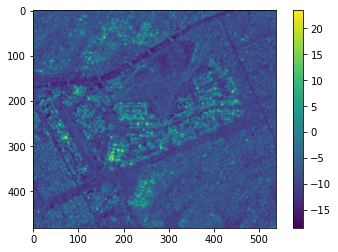

In [ ]:
plt.imshow(s1_np)
plt.colorbar()

(array([[  7., 139., 239., ...,   0.,   0.,   0.],
        [  4., 134., 248., ...,   0.,   0.,   0.],
        [  1., 104., 275., ...,   0.,   0.,   0.],
        ...,
        [  2., 117., 323., ...,   0.,   0.,   0.],
        [  0., 113., 320., ...,   0.,   0.,   0.],
        [  1., 100., 337., ...,   0.,   0.,   0.]]),
 array([-18.48356552, -14.29511133, -10.10665714,  -5.91820294,
         -1.72974875,   2.45870544,   6.64715963,  10.83561382,
         15.02406801,  19.21252221,  23.4009764 ]),
 <a list of 538 Lists of Patches objects>)

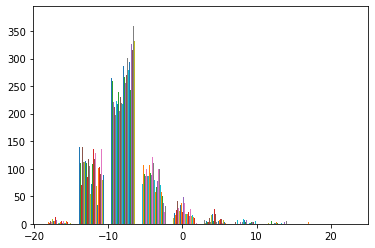

In [ ]:
plt.hist(s1_np)

In [ ]:
s2_np_swaped = np.swapaxes(s2_np,2,0)
s2_np_swaped = np.swapaxes(s2_np_swaped,1,0)
print(s2_np_swaped.shape)

(482, 538, 12)


In [ ]:
s2_np_oneband = s2_np_swaped[:,:,1]
print(np.min(s2_np_oneband),np.max(s2_np_oneband))
# s2_np_oneband = s2_np_oneband/np.max(s2_np_oneband)
# s2_np_oneband = s2_np_oneband * 255
# s2_np_oneband = s2_np_oneband.astype('uint8')

0.0425 0.8164


(482, 538)


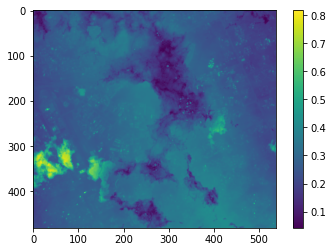

In [ ]:
print(s2_np_oneband.shape)
plt.imshow(s2_np_oneband)
plt.colorbar()

# Downlaod All!

In [ ]:
import pandas as pd
import ast
import collections
import os
import shutil

In [ ]:
rois_path = '/content/drive/MyDrive/Colab Notebooks/rgb2sar/ROIs.xlsx'

In [ ]:
df = pd.read_excel(rois_path)

In [ ]:
row = df.loc[0]
print(row['name']+str(row['year_type']))

aguasclaras20


## checking if there is a duplicate in the names

In [ ]:
names = []
for index, row in df.iterrows():
    names.append(row['name']+str(row['year_type']))

In [ ]:
print([item for item, count in collections.Counter(names).items() if count > 1])

[]


## retriving every element

In [ ]:
print(row['name']+str(row['year_type']))
print(ast.literal_eval(row['roi']))
print(row['date'])
print(row['priority_path'])
print(row['max_cloud'])
print(row['max_snow'])
print(row['month_span'])
print(row['retry_days'])
print(row['type'])

abudhabi_buffed22
[[[54.453049, 24.297666], [54.453049, 24.444649], [54.700241, 24.444649], [54.700241, 24.297666], [54.453049, 24.297666]]]
('2022-01-26', '2022-02-25')
ASCENDING
5
5
2
0
buff


In [ ]:
# r_roi = ast.literal_eval(row['roi'])
# r_roi = ee.Geometry.Polygon(r_roi, None, False)

# r_pp =  row['priority_path']
# r_mc =  int(row['max_cloud'])
# r_ms =  int(row['max_snow'])
# r_ms =  int(row['month_span'])
# r_rd =  int(row['retry_days'])

# s2_col,s1_col = s1s2(r_roi , date = r_date , priority_path = r_pp , max_cloud =r_mc , max_snow = r_ms , month_span = r_ms ,retry_days = r_rd)

In [ ]:
if not os.path.exists('/content/s1_imgs/'):
  os.mkdir('/content/s1_imgs/')
  os.mkdir('/content/s2_imgs/')

removing folders

In [ ]:
#shutil.rmtree('/content/s2_imgs/')  

### dataset downlaoder

In [ ]:
# bands = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12']
# for index, row in df.iterrows():
#     print("🟥🟥🟥",row['name']+str(row['year_type']),"🟥🟥🟥")
#     r_roi = ast.literal_eval(row['roi'])
#     r_roi = ee.Geometry.Polygon(r_roi, None, False)
#     r_date = ast.literal_eval(row['date'])
#     r_pp =  row['priority_path']
#     r_mc =  int(row['max_cloud'])
#     r_ms =  int(row['max_snow'])
#     r_ms =  int(row['month_span'])
#     r_rd =  int(row['retry_days'])

#     s2_col,s1_col = s1s2(r_roi , date = r_date , priority_path = r_pp , max_cloud =r_mc , max_snow = r_ms , month_span = r_ms ,retry_days = r_rd)
#     s1_col = s1_col.map(toLinear) # convers dB values to Linear, and adds band 'VV_lin' to the images of the collection
#     #===============================================
#     s1_img = s1_col.mean().clip(r_roi)
#     s1_img = toDb(s1_img) # reads the 'VV_lin' and returns the image with the added band 'VV_db' 
#     s2_img = s2_col.median().clip(r_roi).multiply(0.0001)

#     s1_img_vv = s1_img.select('VV_db')
#     s2_img_12b = s2_img.select(bands)
    
#     r_name = str(index+1).zfill(3) + '_' + row['name'] + str(row['year_type'])
#     geemap.download_ee_image(s1_img_vv, '/content/s1_imgs/'+r_name+".tif",crs='EPSG:4326', scale=10,region = r_roi)
#     geemap.download_ee_image(s2_img_12b, '/content/s2_imgs/'+r_name+".tif",crs='EPSG:4326', scale=10,region = r_roi)

🟥🟥🟥 aguasclaras20 🟥🟥🟥
◍◍Finding S2
◍Single scene coverege was fount!
◍◍Finding S1
mean date:  2020-09-12
final date range:  2020-07-12 2020-11-12
Snowy days       :  []
Snowy days Buffed:  []
◍checking for DESCENDING single scene
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 258834 / All Pixels = 258834
Mosaic Coverege Accepted
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 258834 / All Pixels = 258834
Mosaic Coverege Accepted
collection size before removing snowy dates:  10
collection size after removing snowy dates:  10
◍Collection Found!


001_aguasclaras20.tif: |          | 0.00/2.07M (raw) [  0.0%] in 00:00 (eta:     ?)

001_aguasclaras20.tif: |          | 0.00/24.9M (raw) [  0.0%] in 00:00 (eta:     ?)

🟥🟥🟥 aguasclaras22 🟥🟥🟥
◍◍Finding S2
◍Single scene coverege was fount!
◍◍Finding S1
mean date:  2022-09-07
final date range:  2022-07-07 2022-11-07
Snowy days       :  []
Snowy days Buffed:  []
◍checking for DESCENDING single scene
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 258834 / All Pixels = 258834
Mosaic Coverege Accepted
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 258834 / All Pixels = 258834
Mosaic Coverege Accepted
collection size before removing snowy dates:  11
collection size after removing snowy dates:  11
◍Collection Found!


002_aguasclaras22.tif: |          | 0.00/2.07M (raw) [  0.0%] in 00:00 (eta:     ?)

002_aguasclaras22.tif: |          | 0.00/24.9M (raw) [  0.0%] in 00:00 (eta:     ?)

🟥🟥🟥 aguasclaras_buffed20 🟥🟥🟥
◍◍Finding S2
◍Single scene coverege was fount!
◍◍Finding S1
mean date:  2020-09-12
final date range:  2020-07-12 2020-11-12
Snowy days       :  []
Snowy days Buffed:  []
◍checking for DESCENDING single scene
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 44088 / All Pixels = 44088
Mosaic Coverege Accepted
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 44088 / All Pixels = 44088
Mosaic Coverege Accepted
collection size before removing snowy dates:  10
collection size after removing snowy dates:  10
◍Collection Found!


003_aguasclaras_buffed20.tif: |          | 0.00/35.5M (raw) [  0.0%] in 00:00 (eta:     ?)

003_aguasclaras_buffed20.tif: |          | 0.00/425M (raw) [  0.0%] in 00:00 (eta:     ?)

🟥🟥🟥 aguasclaras_buffed22 🟥🟥🟥
◍◍Finding S2
◍Single scene coverege was fount!
◍◍Finding S1
mean date:  2022-09-07
final date range:  2022-07-07 2022-11-07
Snowy days       :  []
Snowy days Buffed:  []
◍checking for DESCENDING single scene
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 44088 / All Pixels = 44088
Mosaic Coverege Accepted
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 44088 / All Pixels = 44088
Mosaic Coverege Accepted
collection size before removing snowy dates:  11
collection size after removing snowy dates:  11
◍Collection Found!


004_aguasclaras_buffed22.tif: |          | 0.00/35.5M (raw) [  0.0%] in 00:00 (eta:     ?)

004_aguasclaras_buffed22.tif: |          | 0.00/425M (raw) [  0.0%] in 00:00 (eta:     ?)

🟥🟥🟥 aguasclaras_adj_goiania20 🟥🟥🟥
◍◍Finding S2
◍Single scene coverege was fount!
◍◍Finding S1
mean date:  2020-09-14
final date range:  2020-08-14 2020-10-14
Snowy days       :  []
Snowy days Buffed:  []
◍checking for DESCENDING single scene
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 523124 / All Pixels = 523124
Mosaic Coverege Accepted
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 523124 / All Pixels = 523124
Mosaic Coverege Accepted
collection size before removing snowy dates:  10
collection size after removing snowy dates:  10
◍Collection Found!


005_aguasclaras_adj_goiania20.tif: |          | 0.00/4.19M (raw) [  0.0%] in 00:00 (eta:     ?)

005_aguasclaras_adj_goiania20.tif: |          | 0.00/50.3M (raw) [  0.0%] in 00:00 (eta:     ?)

🟥🟥🟥 aguasclaras_adj_goiania22 🟥🟥🟥
◍◍Finding S2
◍Single scene coverege was fount!
◍◍Finding S1
mean date:  2022-08-31
final date range:  2022-07-31 2022-09-30
Snowy days       :  []
Snowy days Buffed:  []
◍checking for DESCENDING single scene
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 523124 / All Pixels = 523124
Mosaic Coverege Accepted
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 523124 / All Pixels = 523124
Mosaic Coverege Accepted
collection size before removing snowy dates:  10
collection size after removing snowy dates:  10
◍Collection Found!


006_aguasclaras_adj_goiania22.tif: |          | 0.00/4.19M (raw) [  0.0%] in 00:00 (eta:     ?)

006_aguasclaras_adj_goiania22.tif: |          | 0.00/50.3M (raw) [  0.0%] in 00:00 (eta:     ?)

🟥🟥🟥 beihai20 🟥🟥🟥
◍◍Finding S2
◍Single scene coverege was fount!
◍◍Finding S1
mean date:  2020-12-05
final date range:  2020-11-05 2021-01-05
Snowy days       :  ['2020-12-13']
Snowy days Buffed:  ['2020-12-11', '2020-12-12', '2020-12-13', '2020-12-14', '2020-12-15']
◍checking for ASCENDING single scene
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 754017 / All Pixels = 754017
Mosaic Coverege Accepted
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 754017 / All Pixels = 754017
Mosaic Coverege Accepted
collection size before removing snowy dates:  10
image with index: 8  removed
collection size after removing snowy dates:  9
◍Collection Found!


007_beihai20.tif: |          | 0.00/6.03M (raw) [  0.0%] in 00:00 (eta:     ?)

007_beihai20.tif: |          | 0.00/72.4M (raw) [  0.0%] in 00:00 (eta:     ?)

🟥🟥🟥 beihai_buffed20 🟥🟥🟥
◍◍Finding S2
◍Single scene coverege was fount!
◍◍Finding S1
mean date:  2020-12-05
final date range:  2020-10-05 2021-02-05
Snowy days       :  ['2020-10-14']
Snowy days Buffed:  ['2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16']
◍checking for ASCENDING single scene
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 30400 / All Pixels = 30400
Mosaic Coverege Accepted
Mosiac Covers 100.0 percent of the roi  - detail:  Image Pixels = 30400 / All Pixels = 30400
Mosaic Coverege Accepted
collection size before removing snowy dates:  9
image with index: 0  removed
collection size after removing snowy dates:  8
◍Collection Found!


008_beihai_buffed20.tif: |          | 0.00/24.3M (raw) [  0.0%] in 00:00 (eta:     ?)

KeyboardInterrupt: ignored

In [ ]:
! du -sh /content/s1_imgs/
! du -sh /content/s2_imgs/

4.0K	/content/s1_imgs/
4.0K	/content/s2_imgs/


# Translate Js to Python

In [ ]:
js_snippet = """
function toLinear(db) {
  return db.addBands(
    ee.Image().expression('pow(10, db / 10)', {
      db: db.select(['VV', 'VH'])
    }),
    null, true // Replace the bands to keep image properties
  )
}
"""

lines = geemap.js_snippet_to_py(js_snippet, add_new_cell=False, import_ee=True, import_geemap=True, show_map=True)
for line in lines:
    print(line.rstrip())

import ee
import geemap
Map = geemap.Map()

def toLinear(db):
  return db.addBands(
    ee.Image().expression('pow(10, db / 10)', {
      'db': db.select(['VV', 'VH'])
    }),
    None, True # Replace the bands to keep image properties
  )

Map


In [ ]:
print('hello')

hello


## Saving downloaded dataset for later use in drive

In [ ]:
# from distutils.dir_util import copy_tree
# copy_tree("/content/s1_imgs", "/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/s1")
# copy_tree("/content/s2_imgs", "/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/s2")

# patching the files

## importing patch function
`perfect_patchify` is what I worte on my own.

we also install and import `patchify` library

In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/rgb2sar/pyModules/')
from patch_perfect import perfect_patchify

In [ ]:
from patchify import patchify

##loading the data from drive to working directory

In [ ]:
from distutils.dir_util import copy_tree
copy_tree("/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/s1","/content/s1_imgs")
copy_tree("/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/s2","/content/s2_imgs")

KeyboardInterrupt: ignored

In [ ]:
from skimage import io

## patchify s2 images

In [ ]:
geo_context = {
    'abudhabi':1,
    'dubai':1,
    'aguasclaras':2,
    'brasilia':2,
    'bercy':3,
    'paris':3,
    'saclay_e':3,
    'saclay_w':3,
    'bordeaux':4,
    'nantes':5,
    'rennes':6,
    'montpellier':7,
    'pisa':8,
    'norcia':9,
    'milano':10,
    'valencia':11,
    'chongqing':12,
    'beihai':13,
    'hongkong':14,
    'cupertino':15,
    'lasvegas':16,
    'beirut':17,
    'rio':18,
    'mumbai':19
}

In [ ]:
def add_geo_context(img,img_name:str,geo_dict:dict, norm_factor=20):
    for key in  geo_dict.keys():
        if key in img_name:
            print('matched ', key)
            const_layer = np.ones((img.shape[0],img.shape[1],1)) * (geo_dict[key]/norm_factor)
            #print(const_layer)
            stack_img = np.dstack([img,const_layer])
            break
    else:
        raise('❗️No key matched the name!❗️')
    return stack_img

In [ ]:
# shutil.rmtree('/content/s2_imgs_patched//')

In [ ]:
def shape_correction(image):
  """
  fixing the image dimentions, for some wierd reason, in.imread() 
  reads images with more than 3 (sometimes 4!) channels in a reverse order like: (12, 1325, 3345) instead of (1325, 3345,12)
  so we fist check if the image is multy channel, if it is multichanenl, then we check if shape[0] is les than shape[2], and since in
  our case dimenstion of images are always bigger than number of channels, if this condition is not true, it means that the shape
  is in reverse order, so we swap the axis to fix this issue.
  """
  x = image
  print(x.shape)
  if (len(x.shape)==3):
      if x.shape[0]<x.shape[2] :
          z = np.swapaxes(x, 2,0)
          img = np.swapaxes(z, 1,0)
      else:
          img = x
  else:
      img = np.expand_dims(x,axis=2)
  return img

In [ ]:
def nan_remover(image,nan_threshhold = 1):
  """
  Inputs
  ---
  `image`: a nd numpy array
  `nan_threshhold`: the precentaage of nans that is acceptable
  """
  nan_ratio = (np.count_nonzero(np.isnan(image))/image.size) * 100
  print(f'NaN Ratio: {nan_ratio} Percent')
  if nan_ratio > nan_threshhold:
    print(f'⚠️ High NaN ratio! ⚠️')

  image[np.isnan(image)] = 0.01
  return image

In [ ]:
if not os.path.exists('/content/s1s2'):
  os.mkdir('/content/s1s2')

In [ ]:
if not os.path.exists('/content/s1s2/s1_imgs_patched//'):
  os.mkdir('/content/s1s2/s1_imgs_patched//')
if not os.path.exists('/content/s1s2/s2_imgs_patched//'):
  os.mkdir('/content/s1s2/s2_imgs_patched//')

In [ ]:
path = '/content/s2_imgs//'
opath = '/content/s1s2/s2_imgs_patched//'
files = os.listdir(path)
files.sort()

for file in files:
    print('📍📍📍🗺️ \033[92m', file ,'\033[0m 🗺️📍📍📍')
    x=io.imread(path+file)
    img = shape_correction(x)
    print(img.shape)



    print("range before norm: ",np.min(img),np.mean(img),np.std(img),np.max(img))

    print(img.shape) #sanity check to see if masks are the same size as images
    
    img = add_geo_context(img,file,geo_context)

    

    img[img>0.99] = 0.99
    img[img<0] = 0
    img = nan_remover(img)

    print("range after norm and NaN removal: ",np.min(img),np.mean(img),np.std(img),np.max(img))

    if ('adj' in file) or ('buffed' in file):
      print('🟥not main')
      patches = perfect_patchify(img,mute=True)
    else:
      print('🟦main')
      patches = patchify(img,(256,256,13),step=128)
      patches = patches[:,:,0,:,:,:]
    
    print('✅',patches.shape)

    # SAVING PATHCES
    img_index = file[0:3]
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i,j,:,:,:]
            #print(patch.shape)
            patch = np.swapaxes(patch, 2,0)
            patch= np.swapaxes(patch, 1,2)
            
            io.imsave(opath +img_index+ '_r'+ str(i).zfill(2) + '_c' + str(j).zfill(2) + '.tif', patch)

## checking the NaN ratio

In [ ]:
! du -sh /content/s1s2/s2_imgs_patched//

In [ ]:
patched_s2 = os.listdir('/content/s1s2/s2_imgs_patched//')
print(len(patched_s2))

In [ ]:
# s2_test = io.imread('/content/s2_imgs/013_beirut20.tif')

# p=s2_test
# print(p.shape)
# if (len(p.shape)==3):
#     if p.shape[0]<p.shape[2] :
#         q = np.swapaxes(p, 2,0)
#         s2_test = np.swapaxes(q, 1,0)
#     else:
#         s2_test = p
# else:
#     s2_test = np.expand_dims(p,axis=2)


# print(s2_test.shape)

# print(np.min(s2_test),np.mean(s2_test),np.max(s2_test))
# print(np.count_nonzero(np.isnan(s2_test)))
# s2_test[np.isnan(s2_test)] = 0
# print(np.min(s2_test),np.mean(s2_test),np.max(s2_test))
# # s2_test[np.isnan(s2_test)] = 100
# # s2_test[~np.isnan(s2_test)] = 0
# plt.imshow(s2_test[:,:,[3,2,1]])
# plt.colorbar()


In [ ]:
path = '/content/s1_imgs//'
opath = '/content/s1s2/s1_imgs_patched//'
files = os.listdir(path)
files.sort()

for file in files:
    print('📍📍📍🗺️ \033[92m', file ,'\033[0m 🗺️📍📍📍')
    x=io.imread(path+file)
    img = shape_correction(x)
    print(img.shape)



    print("range before norm: ",np.min(img),np.mean(img),np.std(img),np.max(img))

    print(img.shape) #sanity check to see if masks are the same size as images
    
    #img = add_geo_context(img,file,geo_context)

    

    img[img>15] = 15
    img[img<-25] = -25
    img = nan_remover(img)

    print("range after norm and NaN removal: ",np.min(img),'\033[96m',np.mean(img),np.std(img),'\033[0m',np.max(img))

    if ('adj' in file) or ('buffed' in file):
      print('🟥not main')
      patches = perfect_patchify(img,mute=True)
    else:
      print('🟦main')
      patches = patchify(img,(256,256,1),step=128)
      patches = patches[:,:,0,:,:,:]
    
    print('✅',patches.shape)

    # SAVING PATHCES
    img_index = file[0:3]
    for i in range(patches.shape[0]):
        for j in range(patches.shape[1]):
            patch = patches[i,j,:,:,:]
            #print(patch.shape)
            # patch = np.swapaxes(patch, 2,0)
            # patch= np.swapaxes(patch, 1,2)
            
            io.imsave(opath +img_index+ '_r'+ str(i).zfill(2) + '_c' + str(j).zfill(2) + '.tif', patch)

## checking if the dimentions are  correct

In [ ]:
x=io.imread('/content/s1s2/s1_imgs_patched/000_r00_c01.tif')
# img = shape_correction(x)
print(x.shape)
plt.imshow(x[:,:,0])
# plt.imshow(x[3,:,:])

In [ ]:
x=io.imread('/content/s1s2/s2_imgs_patched/000_r00_c01.tif')
# img = shape_correction(x)
print(x.shape)
# plt.imshow(x[:,:,0])
plt.imshow(x[2,:,:])

In [ ]:
! du -sh /content/s1s2/s1_imgs_patched//

In [ ]:
patched_s1 = os.listdir('/content/s1s2/s1_imgs_patched//')
print(len(patched_s1))

## converting the patched folders into zip files

In [ ]:
!zip -r '/content/s1s2.zip' '/content/s1s2'

In [ ]:
! du -sh /content/s1s2.zip

In [ ]:
# from IPython.display import FileLink
# FileLink(r's1s2.zip')

In [ ]:
!cp "/content/s1s2.zip" "/content/drive/MyDrive/Colab Notebooks/rgb2sar/dataset/"